## GETTING THE DATASETS

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- `dataset.zip` is the COCO 2017 val dataset, cropped to 256x256 and pixelated

In [ ]:
!unzip /content/drive/MyDrive/DEPIXELATOR_004/dataset.zip

In [ ]:
!mv /content/content/drive/MyDrive/DEPIXELATOR_003/x/* /content/x/
!mv /content/content/drive/MyDrive/DEPIXELATOR_003/y/* /content/y/

In [ ]:
import os
print(len(os.listdir('/content/x/')))
print(len(os.listdir('/content/y/')))

7996
7996


## IMPORTING THE LIBRARIES

upgrading these libraries to the latest version

In [ ]:
%pip install --upgrade pip
%pip install --upgrade tensorflow
%pip install --upgrade scikit-learn
%pip install --upgrade pydot
%pip install --upgrade matplotlib

## IN CASE YOU ARE FACING ISSUES WHILE LOADING MODELS OR IMPORTING LIBRARIES YOU CAN
## USE THE VERSIONS OF THESE LIBRARIES ON WHICH OUR MODEL WAS CREATED

# %pip install --upgrade pip==24.1.1
# %pip install --upgrade ipykernel==5.5.6
# %pip install --upgrade numpy==1.25.2
# %pip install --upgrade pandas==2.0.3
# %pip install --upgrade tensorflow==2.16.2
# %pip install --upgrade keras==3.4.1
# %pip install --upgrade scikit-learn==1.5.0
# %pip install --upgrade matplotlib==3.9.0
# %pip install --upgrade pydot==2.0.0

In [1]:
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.applications import VGG19, vgg19
import matplotlib.pyplot as plt

## DATASET OBJECT CREATION

getting the `pixelated_image_paths` and corresponding `ground_truth_image_paths` as lists

In [ ]:
pixelated_dir = './x/'
ground_truth_dir = './y/'

pixelated_images = [os.path.join(pixelated_dir, fname) for fname in sorted(os.listdir(pixelated_dir))]
ground_truth_images = [os.path.join(ground_truth_dir, fname.split('_')[0] + '.png') for fname in sorted(os.listdir(pixelated_dir))]

In [ ]:
# CHECKING

print(len(pixelated_images))
print(len(ground_truth_images))

print(pixelated_images)
print(ground_truth_images)

for file in ground_truth_images:
   if not os.path.exists(file):
      print(file, 'doesnt exist')

print(pixelated_images[1234])
print(ground_truth_images[1234])

7996
7996
['./x/00001o_d3.png', './x/00002h_j10.png', './x/00003o_real.png', './x/00004h_j30.png', './x/00005o_real.png', './x/00006h_d5.png', './x/00007o_d4.png', './x/00008h_j30.png', './x/00009o_d4.png', './x/00010h_real.png', './x/00011o_j20.png', './x/00012h_real.png', './x/00013o_d3.png', './x/00014h_real.png', './x/00015o_d5.png', './x/00016h_d4.png', './x/00017o_j30.png', './x/00018h_d4.png', './x/00019o_real.png', './x/00020h_real.png', './x/00021o_real.png', './x/00022h_j20.png', './x/00023o_d4.png', './x/00024h_d3.png', './x/00025o_j20.png', './x/00026h_real.png', './x/00027o_real.png', './x/00028h_j10.png', './x/00029o_real.png', './x/00030h_real.png', './x/00031o_j10.png', './x/00032h_d5.png', './x/00033o_d4.png', './x/00034h_j30.png', './x/00035o_d4.png', './x/00036h_real.png', './x/00037o_real.png', './x/00038h_d3.png', './x/00039o_j10.png', './x/00040h_real.png', './x/00041o_d3.png', './x/00042h_d3.png', './x/00043o_d5.png', './x/00044h_j30.png', './x/00045o_real.png', 

function for loading the image to have values between [0,1]

In [ ]:
def load_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image

def load_data(pixelated_path, ground_truth_path):
    pixelated_image = load_image(pixelated_path)
    ground_truth_image = load_image(ground_truth_path)
    return pixelated_image, ground_truth_image

train, test, validation dataset creations

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((pixelated_images, ground_truth_images))

total_size = dataset.cardinality()
dataset = dataset.shuffle(buffer_size=total_size)

train_size = int(0.75 * int(total_size))
val_size = int(0.10 * int(total_size))

train_dataset = dataset.take(train_size)
rem = dataset.skip(train_size)
val_dataset = rem.take(val_size)
test_dataset = rem.skip(val_size)

batch_size = 16
train_dataset = train_dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)\
                             .batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)\
                             .prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset   =   val_dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)\
                             .batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)\
                             .prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset  =  test_dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)\
                             .batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)\
                             .prefetch(buffer_size=tf.data.AUTOTUNE)

## CREATE MODEL

Full model architecture (for a visual representation see output)

In [2]:
def build_net(input_shape=(None, None, 3)):

  inputs = tfl.Input(input_shape)

  def translate_encoder(x, filters, kernel_size=3, activation='relu'):
    x = tfl.SeparableConv2D(filters=filters, kernel_size=kernel_size, strides=(1, 1), padding='same', activation=None, use_bias=False)(x)
    x = tfl.BatchNormalization(epsilon=1e-3, momentum = 0.99)(x)
    return tfl.Activation(activation=activation)(x)

  def encoder_block(x, filters, kernel_size=3, strides=2, padding='same', activation='relu'):
    x = tfl.SeparableConv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=None, use_bias=False)(x)
    x = tfl.BatchNormalization(epsilon=1e-3, momentum = 0.99)(x)
    return tfl.Activation(activation=activation)(x)

  def decoder_block(x, filters, skip, kernel_size=3, strides=2, padding='same', activation='relu'):
    x = tfl.UpSampling2D(size=(strides, strides), interpolation='nearest')(x)
    x = tfl.SeparableConv2D(filters=filters, kernel_size=kernel_size, padding=padding, activation=None, use_bias=False)(x)
    x = tfl.BatchNormalization(epsilon=1e-3, momentum = 0.99)(x)
    x = tfl.Activation(activation=activation)(x)
    return tfl.Add()([x, skip])

  def translate_decoder(x, filters, skip, kernel_size=3, activation='relu'):
    x = tfl.SeparableConv2D(filters=filters, kernel_size=kernel_size, strides=(1, 1), padding='same', activation=None, use_bias=False)(x)
    x = tfl.BatchNormalization(epsilon=1e-3, momentum = 0.99)(x)
    x = tfl.Activation(activation=activation)(x)
    return tfl.Add()([x, skip])

  t0 = translate_encoder(inputs, 16)
  t1 = translate_encoder(t0, 32)

  e1 = encoder_block(t1, 64)
  e2 = encoder_block(e1, 128)
  e3 = encoder_block(e2, 256)
  e4 = encoder_block(e3, 512)
  e5 = encoder_block(e4, 1024)

  d5 = decoder_block(e5, 512, e4)
  d4 = decoder_block(d5, 256, e3)
  d3 = decoder_block(d4, 128, e2)
  d2 = decoder_block(d3,  64, e1)
  d1 = decoder_block(d2,  32, t1)

  t2 = translate_decoder(d1, 16, t0)
  t3 = translate_decoder(t2,  3, inputs, activation='linear')
  outputs = tfl.Activation(activation='sigmoid')(t3)

  return tf.keras.Model(inputs, outputs)

model = build_net()

model.summary()
# tf.keras.utils.plot_model(model, to_file='./depixelator_004_2.png', show_layer_activations=True, show_layer_names=True, show_shapes=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, None,      │         75 │ input_layer[0][0] │
│ (SeparableConv2D)   │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, None,      │         64 │ separable_conv2d… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, None,      │        656 │ activation[0][0]  │
│ (SeparableConv2D)   │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        128 │ separable_conv2d… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, None,      │      2,336 │ activation_1[0][… │
│ (SeparableConv2D)   │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_3  │ (None, None,      │      8,768 │ activation_2[0][… │
│ (SeparableConv2D)   │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_4  │ (None, None,      │     33,920 │ activation_3[0][… │
│ (SeparableConv2D)   │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │      1,024 │ separable_conv2d… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_5  │ (None, None,      │    133,376 │ activation_4[0][

 Total params: 1,437,415 (5.48 MB)

 Trainable params: 1,431,329 (5.46 MB)

 Non-trainable params: 6,086 (23.77 KB)

## CUSTOM FUNCTIONS

loading the VGG19 Model for perceptual loss function

In [ ]:
vgg = VGG19(include_top=False, weights='imagenet', input_shape=(None, None, 3))
layer_names = ['block3_conv4', 'block4_conv1', 'block4_conv2']
outputs = [vgg.get_layer(name).output for name in layer_names]
vgg_model = tf.keras.Model(inputs=vgg.input, outputs=outputs)
vgg_model.trainable = False

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


custom loss and metric functions

In [ ]:
@tf.keras.utils.register_keras_serializable()
def compute_perceptual_loss(y_true, y_pred):
    y_true = vgg19.preprocess_input(y_true * 255.0)
    y_pred = vgg19.preprocess_input(y_pred * 255.0)

    true_features = vgg_model(y_true)
    pred_features = vgg_model(y_pred)

    loss = 0
    for t, p in zip(true_features, pred_features):
        loss += tf.reduce_mean(tf.abs(t - p))

    return loss

@tf.keras.utils.register_keras_serializable()
def compute_psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

@tf.keras.utils.register_keras_serializable()
def compute_ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

compiling the model with custom loss and metrics

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=compute_perceptual_loss,
    metrics=[tf.keras.metrics.MeanSquaredError(), compute_psnr, compute_ssim]
)

## TRAINING

initial testing

In [ ]:
perceptual_loss0, pixel_loss0, psnr0, ssim0  = model.evaluate(val_dataset)

50/50 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - compute_psnr: 11.5335 - compute_ssim: 0.4884 - loss: 896.2933 - mean_squared_error: 0.0779


In [ ]:
print("initial perceptual loss: {:.2f}".format(perceptual_loss0))
print("initial pixel loss: {:.2f}".format(pixel_loss0))
print("initial PSNR: {:.2f}".format(psnr0))
print("initial SSIM: {:.2f}".format(ssim0))

initial perceptual loss: 903.24
initial pixel loss: 0.08
initial PSNR: 11.45
initial SSIM: 0.49


required callbacks

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1,
    patience=3,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)

### TRAINING (1-12 epochs)

In [ ]:
history = model.fit(train_dataset,
                    epochs=12,
                    validation_data=val_dataset,
                    callbacks=[early_stopping])

model.save('/content/drive/MyDrive/DEPIXELATOR_004/depixelator_004_2.keras')
model.save('/content/drive/MyDrive/DEPIXELATOR_004/depixelator_004_2.h5')

Epoch 1/12
375/375 ━━━━━━━━━━━━━━━━━━━━ 705s 2s/step - compute_psnr: 15.3638 - compute_ssim: 0.6081 - loss: 742.3759 - mean_squared_error: 0.0374 - val_compute_psnr: 17.2536 - val_compute_ssim: 0.6655 - val_loss: 678.9356 - val_mean_squared_error: 0.0198
Epoch 2/12
375/375 ━━━━━━━━━━━━━━━━━━━━ 525s 1s/step - compute_psnr: 19.3434 - compute_ssim: 0.7103 - loss: 555.5149 - mean_squared_error: 0.0129 - val_compute_psnr: 19.9661 - val_compute_ssim: 0.7240 - val_loss: 538.2248 - val_mean_squared_error: 0.0107
Epoch 3/12
375/375 ━━━━━━━━━━━━━━━━━━━━ 571s 1s/step - compute_psnr: 21.3720 - compute_ssim: 0.7221 - loss: 533.9988 - mean_squared_error: 0.0088 - val_compute_psnr: 22.3604 - val_compute_ssim: 0.7437 - val_loss: 503.8843 - val_mean_squared_error: 0.0067
Epoch 4/12
375/375 ━━━━━━━━━━━━━━━━━━━━ 535s 1s/step - compute_psnr: 22.9596 - compute_ssim: 0.7355 - loss: 511.4113 - mean_squared_error: 0.0064 - val_compute_psnr: 22.7788 - val_compute_ssim: 0.7428 - val_loss: 500.0814 - val_mean_sq

### RESULTS

In [ ]:
def history_results(history, par1='loss', par2='val_loss', title='Perceptual Loss'):
    plt.plot(history.history[par1])
    plt.plot(history.history[par2])
    plt.title(title)
    plt.ylabel(par1)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.grid()
    plt.show()
    return

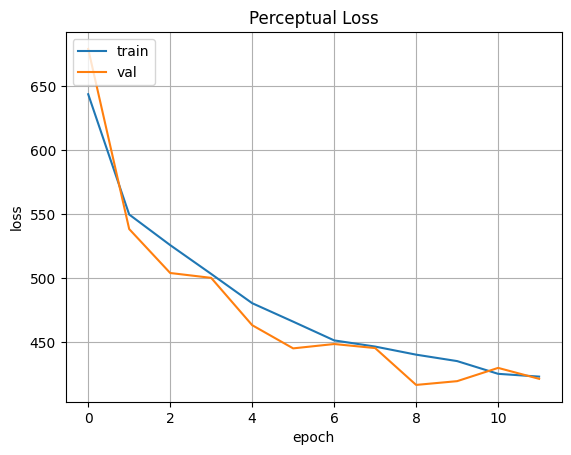

In [ ]:
history_results(history)

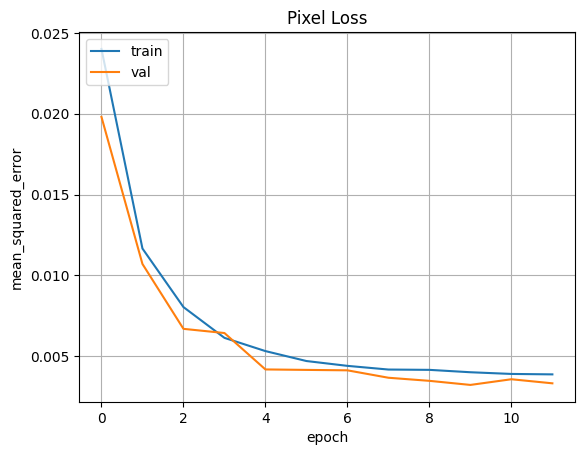

In [ ]:
history_results(history, 'mean_squared_error', 'val_mean_squared_error', 'Pixel Loss')

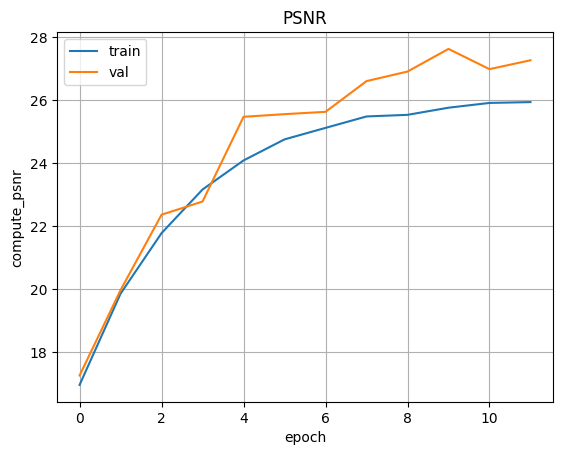

In [ ]:
history_results(history, 'compute_psnr', 'val_compute_psnr', 'PSNR')

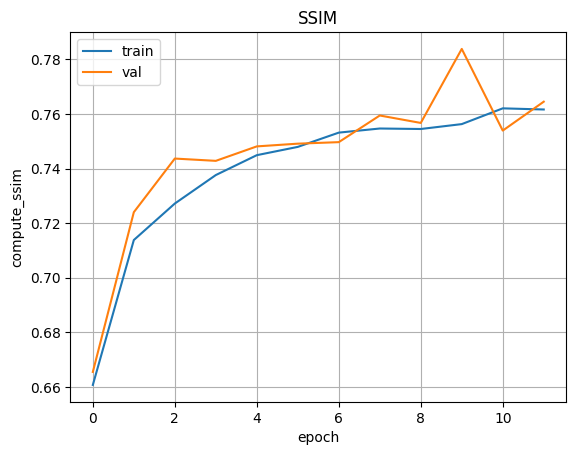

In [ ]:
history_results(history, 'compute_ssim', 'val_compute_ssim', 'SSIM')

In [ ]:
perceptual_loss_test, pixel_loss_test, psnr_test, ssim_test = model.evaluate(test_dataset)

75/75 ━━━━━━━━━━━━━━━━━━━━ 48s 639ms/step - compute_psnr: 27.6186 - compute_ssim: 0.7796 - loss: 386.0658 - mean_squared_error: 0.0032


In [ ]:
print("perceptual loss: {:.2f}".format(perceptual_loss_test))
print("pixel loss: {:.2f}".format(pixel_loss_test))
print("PSNR: {:.2f}".format(psnr_test))
print("SSIM: {:.2f}".format(ssim_test))

perceptual loss: 399.97
pixel loss: 0.00
PSNR: 27.25
SSIM: 0.77
